# Importing the libraries

In [1]:
import sys
!{sys.executable} -m pip install dicomsdl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 2.9 MB/s eta 0:00:00


In [2]:
#!pip install /kaggle/input/rsnapacks/dicomsdl-0.109.1-cp36-cp36m-manylinux_2_12_x86_64.manylinux2010_x86_64.whl


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#import pydicom as dicom
import dicomsdl as dicom
import tensorflow as tf
import tensorflow_io as tfio
import os
from tqdm import tqdm
import cv2
from PIL import Image
from joblib import Parallel, delayed
import gc

# Reading the training dataset of breast cancer patients

In [4]:
train_data = pd.read_csv('/kaggle/input/rsna-breast-cancer-detection/train.csv')


In [5]:
print(train_data)

       site_id  patient_id    image_id laterality view   age  cancer  biopsy  \
0            2       10006   462822612          L   CC  61.0       0       0   
1            2       10006  1459541791          L  MLO  61.0       0       0   
2            2       10006  1864590858          R  MLO  61.0       0       0   
3            2       10006  1874946579          R   CC  61.0       0       0   
4            2       10011   220375232          L   CC  55.0       0       0   
...        ...         ...         ...        ...  ...   ...     ...     ...   
54701        1        9973  1729524723          R  MLO  43.0       0       0   
54702        1        9989    63473691          L  MLO  60.0       0       0   
54703        1        9989  1078943060          L   CC  60.0       0       0   
54704        1        9989   398038886          R  MLO  60.0       0       0   
54705        1        9989   439796429          R   CC  60.0       0       0   

       invasive  BIRADS  implant densit

In [6]:
path_train_imgs = '/kaggle/input/rsna-breast-cancer-detection/train_images/'

patient_ids = train_data['patient_id']
image_ids = train_data['image_id']
sides  = train_data['laterality']

train_img_data = []
for pi, ii, leng in zip(patient_ids, image_ids, range(len(patient_ids))):
    train_img_data.append(path_train_imgs + str(pi) + '/' + str(ii) + '.dcm')
   
train_data['img_data'] = " "

def crop(sideName, imgName):
    if sideName == 'L':
        colind=[]
        for r,row in enumerate(imgName):
            for c,col in enumerate(row):
                if col==0:
                    colind.append(c)
                    break
        crop_size = max(colind)
        imgName = imgName[0:512,0:crop_size]
        imgName = cv2.resize(imgName,(128,128))
        
    if sideName == 'R':
        colind=[]
        for r,row in enumerate(imgName):
            for c,col in enumerate(row):
                if col!=0:
                    colind.append(c)
                    break
        crop_size = min(colind)
        imgName = imgName[0:512,crop_size:512]
        imgName = cv2.resize(imgName,(128,128))
    
    return imgName    

    gc.collect()
    

def img_process(i,filename):
    
    #ds = dicom.dcmread(filename)
    ds = dicom.open(filename)
    ds = ds.pixelData()
    ds = cv2.normalize(ds, None, 0, 1.0, cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    
    ds = cv2.resize(ds,(512,512))
    ds = np.where(ds >= 0.9999, 0,ds)
   
    try:
        ds = crop(sides[i], ds)
        
        
    except:
        ds = np.zeros((128, 128))
       
    #train_data.loc[i,'img_data'] = [img_fin]
    #train_data.to_csv('/kaggle/working/training_img_data.csv') 
    return ds
    gc.collect()
    
    
    
    

    
    



In [7]:
#for i, fname in zip(range(len(train_img_data[:2])),tqdm(train_img_data[:2])):
    
    #img_process(i,fname)
    
   
    #gc.collect()


result = Parallel(n_jobs=128)(\
    delayed(img_process)(i, fname) for i, fname in zip(range(len(train_img_data)),tqdm(train_img_data))\
    )



100%|█████████▉| 54705/54706 [5:33:40<00:00,  2.73it/s]


In [8]:
train_data['img_data'] = result

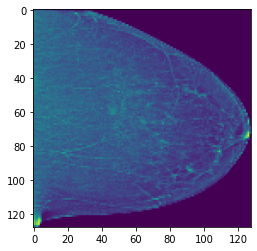

In [9]:

train_data.to_csv('training_img_data.csv')
plt.imshow(train_data['img_data'][78])